### Conversion of RAW format to H5 with some tweaks:
- each folder contains RAW datasets taken with different zooms
- for every zoom, all channels need to be merged into single H5
- left and right illuminations need to be converted into separate H5 files

### Dependencies
- [npy2bdv (>=1.0.7)](https://github.com/nvladimus/npy2bdv), can be installed via `pip install npy2bdv`

In [ ]:
! pip install npy2bdv # run this only once

In [5]:
import npy2bdv
import numpy as np
import glob

In [4]:
data_path = 'E:\\'
data_folders = {
    'Dbx1': data_path + 'Dbx1_TD_L85p6_P6\\'
}

In [12]:
label = 'Dbx1'
raw_files = glob.glob(data_folders[label] + "\\*.raw").sort()
meta_files = glob.glob(data_folders[label] + "\\*.raw_meta.txt").sort()
assert len(raw_files) == len(meta_files), "Raw and meta-file counts don't match"

In [16]:
def nonblank_lines(f):
    for l in f:
        line = l.rstrip()
        if line:
            yield line

In [24]:
# extract meta-information from the txt files and store as list of dictionaries
meta_list = []
for raw, meta in zip(raw_files, meta_files):
    meta_dict = {}
    with open(meta) as f:
        lines = nonblank_lines(f)
        for line in lines:
            if line.split()[0] == "[Zoom]":
                meta_dict["zoom"] = line.split()[1]
            elif line.split()[0] == "[Shutter]":
                meta_dict["shutter"] = line.split()[1]
            elif line.split()[0] == "[Laser]":
                meta_dict["laser"] = line.split()[1]
            elif line.split()[0] == "[z_start]":
                meta_dict["z_start"] = float(line.split()[1])
            elif line.split()[0] == "[z_end]":
                meta_dict["z_end"] = float(line.split()[1])
            elif line.split()[0] == "[z_planes]":
                meta_dict["z_planes"] = int(line.split()[1])
            elif line.split()[0] == "[x_pixels]":
                meta_dict["x_pixels"] = int(line.split()[1])
            elif line.split()[0] == "[y_pixels]":
                meta_dict["y_pixels"] = int(line.split()[1])
    meta_dict["raw_file"] = raw
    meta_list.append(meta_dict)

In [19]:
len(meta_list)

4

In [25]:
meta_list[0]

{'z_planes': 1440,
 'laser': '488',
 'zoom': '1x',
 'shutter': 'Left',
 'z_start': 63400.0,
 'z_end': 70600.0,
 'x_pixels': 2048,
 'y_pixels': 2048,
 'raw_file': 'E:\\Dbx1_TD_L85p6_P6\\Dbx1_L85p6_P6_1x_left_repeat_X-1765_Y-95240_rot_9_488_nm_405-488-561-640-Quadrupleblock_1x_Left_000000.raw'}

In [22]:
stack = np.fromfile(raw_files[0], dtype='uint16').reshape((meta_list[0]['z_planes'], meta_list[0]['x_pixels'], meta_list[0]['y_pixels']))

In [33]:
stack.shape

(6039797760,)

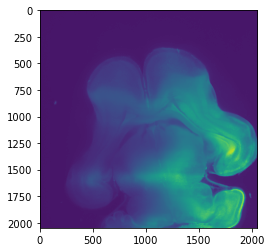

In [32]:
# Sanity check: plot a plane to make sure import is correct
from matplotlib import pyplot as plt
plt.imshow(s[700,:,:])

### Proces individual dataset pairs (2 channels, one illumination into a single h5)

In [41]:
zoom = '1x'
shutter = 'Left'

fname = data_folders[label] + zoom +'_all_ch_' + shutter + '.h5'
bdv_writer = npy2bdv.BdvWriter(fname, nchannels=2)
bdv_writer.set_attribute_labels('channel', ('488', '561'))

for metafile in meta_list:
    if metafile['zoom'] == zoom and metafile['shutter'] == shutter:
        if metafile['laser'] in ('488', '561'):
            stack = np.fromfile(metafile['raw_file'], dtype='uint16').reshape((metafile['z_planes'], 
                                                                       metafile['x_pixels'], 
                                                                       metafile['y_pixels']))
            i_ch = 0 if metafile['laser'] == '488' else 1
            bdv_writer.append_view(stack, channel=i_ch)

bdv_writer.write_xml()
bdv_writer.close()

In [42]:
zoom = '1x'
shutter = 'Right'

fname = data_folders[label] + zoom +'_all_ch_' + shutter + '.h5'
bdv_writer = npy2bdv.BdvWriter(fname, nchannels=2)
bdv_writer.set_attribute_labels('channel', ('488', '561'))

for metafile in meta_list:
    if metafile['zoom'] == zoom and metafile['shutter'] == shutter:
        if metafile['laser'] in ('488', '561'):
            stack = np.fromfile(metafile['raw_file'], dtype='uint16').reshape((metafile['z_planes'], 
                                                                       metafile['x_pixels'], 
                                                                       metafile['y_pixels']))
            i_ch = 0 if metafile['laser'] == '488' else 1
            bdv_writer.append_view(stack, channel=i_ch)

bdv_writer.write_xml()
bdv_writer.close()

### Process all data in the folder 
#### Caution, some bugs may be lurking! Double-check the results before deleting raw data!

In [ ]:
all_zooms = set([m['zoom'] for m in meta_list])
all_shutters = set([m['shutter'] for m in meta_list])
all_channels = list(set([m['laser'] for m in meta_list])).sort()

for zoom in all_zooms:
    for shutter in all_shutters:
        fname = data_folders[label] + zoom +'_all_ch_' + shutter + '.h5'
        bdv_writer = npy2bdv.BdvWriter(fname, nchannels=len(all_channels))
        bdv_writer.set_attribute_labels('channel', tuple(all_channels))

        for metafile in meta_list:
            if metafile['zoom'] == zoom and metafile['shutter'] == shutter:
                stack = np.fromfile(metafile['raw_file'], dtype='uint16').reshape((metafile['z_planes'], 
                                                                           metafile['x_pixels'], 
                                                                           metafile['y_pixels']))
                i_ch = all_channels.index(metafile['laser'])
                bdv_writer.append_view(stack, channel=i_ch)

        bdv_writer.write_xml()
        bdv_writer.close()